In [ ]:
#hide
#all_slow

In [ ]:
#hide
!pip install -Uqq fastai --upgrade
!pip install -Uqq fastcore --upgrade

# Training ResNet18-UNET

> Training notebook for this architecture.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/marcomatteo/steel_segmentation/blob/master/nbs/11_resnet18-UNET.ipynb)

In [ ]:
#hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from steel_segmentation.all import *

import cv2
import fastai
import torch
import numpy as np
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *

import albumentations as alb
import segmentation_models_pytorch as smp

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu"); device

device(type='cuda')

In [ ]:
fastai.__version__, torch.__version__

('2.3.0', '1.7.1+cu101')

In [ ]:
torch.cuda.device_count(), torch.cuda.is_available()

(1, True)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Tue Apr 20 10:26:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro M4000        On   | 00000000:00:05.0 Off |                  N/A |
| 46%   32C    P8    11W / 120W |      4MiB /  8126MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#hide
seed_everything()

## Data

In [ ]:
cond = train_pivot[0] != -1 # no common hard negatives
df = train_pivot.loc[cond]
df.shape

(6666, 6)

In [ ]:
def get_train_aug(height, width, with_gray=False): 
    #alb.CropNonEmptyMaskIfExists(height, width, p=0.5), #added after stage-1
    first_step = alb.RandomCrop(height, width, p=1.0)
    
    second_step = alb.OneOf([alb.VerticalFlip(p=0.5),
                              alb.HorizontalFlip(p=0.5)
                             ], p=0.5)
    
    third_step = alb.OneOf([
        alb.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), 
                                     contrast_limit=(-0.2, 0.2), 
                                     brightness_by_max=True,
                                     p=0.5),
        alb.RandomGridShuffle(always_apply=False, p=0.2, grid=(1, 2))], p=0.5)
    
    # to do: try with grayscale imgs
    gray_step = alb.ToGray(always_apply=False, p=1.0)
    return alb.Compose([first_step, second_step, third_step] + [gray_step] if with_gray else [])

def get_valid_aug(height, width, with_gray=False): 
    first_step = alb.RandomCrop(height, width)
    gray_step = alb.ToGray(always_apply=False, p=1.0)
    return alb.Compose([first_step] + [gray_step] if with_gray else [])

In [ ]:
size = (224,1568)
# size = (128,896)

In [ ]:
train_tfm = get_train_aug(*size)
valid_tfm = get_valid_aug(*size)

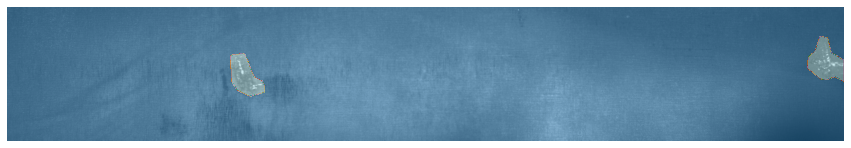

In [ ]:
block = DataBlock(blocks = (ImageBlock,SteelMaskBlock(codes=[1,2,3,4])),
                  get_x = ReadImagePathFromIndex,
                  get_y = ReadRLEs(cols=[1,2,3,4]),
                  splitter = TrainTestSplitter(test_size=0.2),
                  item_tfms=[AlbumentationsTransform(train_tfm, valid_tfm)],
                  batch_tfms=[Normalize.from_stats(*imagenet_stats)])

ds = block.datasets(df)

img, mask = ds.valid[1]
ax = img.show(figsize=(15,5))
mask.show(ctx=ax);

## SMP - Training

In [ ]:
dls = block.dataloaders(source=df, 
                        bs=8, 
                        device=device, 
                        num_workers=0)

In [ ]:
x,y = dls.one_batch()
x.shape, y.shape

(torch.Size([8, 3, 256, 1600]), torch.Size([8, 4, 256, 1600]))

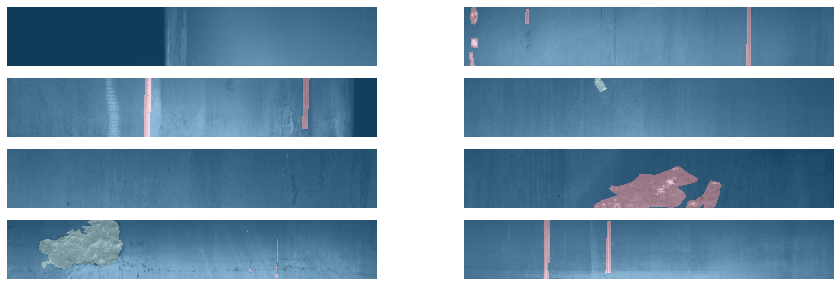

In [ ]:
dls.show_batch(ncols=2, figsize=(15,5))

In [ ]:
arch = smp.Unet('resnet18', classes=4, activation=None, 
                encoder_weights='imagenet',
                decoder_attention_type='scse')

![UNET Architecture](../imgs/unet.png)

In [ ]:
arch.encoder

ResNetEncoder(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=T

In [ ]:
encoder_path = models_dir / "ResNet18-encoder.pt"
state_dict = torch.load(encoder_path)

In [ ]:
len(state_dict)

120

In [ ]:
state_dict.keys()

odict_keys(['0.weight', '1.weight', '1.bias', '1.running_mean', '1.running_var', '1.num_batches_tracked', '4.0.conv1.weight', '4.0.bn1.weight', '4.0.bn1.bias', '4.0.bn1.running_mean', '4.0.bn1.running_var', '4.0.bn1.num_batches_tracked', '4.0.conv2.weight', '4.0.bn2.weight', '4.0.bn2.bias', '4.0.bn2.running_mean', '4.0.bn2.running_var', '4.0.bn2.num_batches_tracked', '4.1.conv1.weight', '4.1.bn1.weight', '4.1.bn1.bias', '4.1.bn1.running_mean', '4.1.bn1.running_var', '4.1.bn1.num_batches_tracked', '4.1.conv2.weight', '4.1.bn2.weight', '4.1.bn2.bias', '4.1.bn2.running_mean', '4.1.bn2.running_var', '4.1.bn2.num_batches_tracked', '5.0.conv1.weight', '5.0.bn1.weight', '5.0.bn1.bias', '5.0.bn1.running_mean', '5.0.bn1.running_var', '5.0.bn1.num_batches_tracked', '5.0.conv2.weight', '5.0.bn2.weight', '5.0.bn2.bias', '5.0.bn2.running_mean', '5.0.bn2.running_var', '5.0.bn2.num_batches_tracked', '5.0.downsample.0.weight', '5.0.downsample.1.weight', '5.0.downsample.1.bias', '5.0.downsample.1.runni

In [ ]:
arch.encoder.load_state_dict(state_dict)

KeyError: 'fc.bias'

In [ ]:
def opt_func(params, **kwargs): return OptimWrapper(params, torch.optim.Adam, **kwargs)
def splitter(m): return convert_params([[m.encoder], [m.decoder], [m.segmentation_head]])

In [ ]:
learn = Learner(dls=dls, 
                model=arch, 
                loss_func=BCEWithLogitsLossFlat(axis=1),
                metrics=[ModDiceMulti(with_logits=True), KaggleDiceMulti], 
                splitter=splitter, 
                opt_func=opt_func, 
                model_dir=models_dir, 
                cbs=[CudaCallback(), ShowGraphCallback()]).to_fp16()

After training a multi label classification model with a `resnet18` encoder in [this notebook](https://colab.research.google.com/github/marcomatteo/steel_segmentation/blob/master/nbs/_10_fastai.classifier.ipynb), I saved the encoder weights to load them in the UNET model to speedup training.

Checking that is all right and freezed up to the encoder part of the network.

In [ ]:
learn.summary()

Unet (Input shape: 8)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 64 x 128 x 800  
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                             

SuggestedLRs(lr_min=0.15848932266235352, lr_steep=1.3182567358016968)

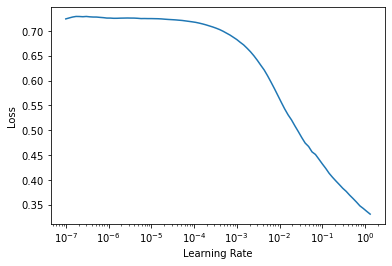

In [ ]:
learn.lr_find()

In [ ]:
stage = "resnet18-UNET-stage0"

In [ ]:
fit_cbs = [
    GradientAccumulation(n_acc=16),
    ReduceLROnPlateau(monitor='valid_loss', patience=2),
    CSVLogger(fname=f'{models_dir}/logs/{stage}.csv'),
    SaveModelCallback(monitor='valid_loss', fname=stage)]

In [ ]:
learn.fit_one_cycle(20, lr_max=1e-3, div=5., cbs=fit_cbs)

epoch,train_loss,valid_loss,mod_dice_multi,single_dice_coef_channel,time


## Fastai DynamicUNET - Training

In [ ]:
dls = block.dataloaders(source=df, 
                        bs=4, 
                        device=device, 
                        num_workers=0)

In [ ]:
fast_learner = unet_learner(dls=dls, 
                            arch=resnet18, 
                            loss_func=BCEWithLogitsLossFlat(axis=1),
                            metrics=[ModDiceMulti(), FastKaggleDiceMulti], 
                            model_dir=models_dir, 
                            cbs=[ShowGraphCallback()]).to_fp16()

In [ ]:
encoder_path = models_dir / "ResNet18-encoder.pt"
state_dict = torch.load(encoder_path)

In [ ]:
fast_learner.model[0].load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
fast_learner.summary()

DynamicUnet (Input shape: 4)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 64 x 128 x 800  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                      

### First stage

SuggestedLRs(lr_min=0.0015848932787775993, lr_steep=2.511886486900039e-05)

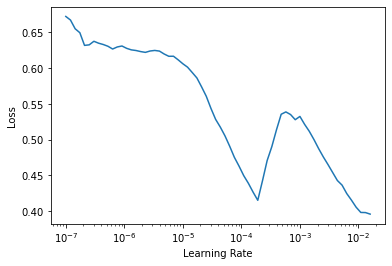

In [ ]:
fast_learner.lr_find()

In [ ]:
stage = "resnet18-DynamicUNET-stage0"

In [ ]:
fit_cbs = [
    GradientAccumulation(n_acc=16),
    CSVLogger(fname=f'{models_dir}/logs/{stage}.csv'),
    SaveModelCallback(monitor='valid_loss', fname=stage), 
    EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=3)]

In [ ]:
fast_learner.fit_one_cycle(4, lr_max=3e-5, cbs=fit_cbs)

epoch,train_loss,valid_loss,mod_dice_multi,single_dice_coef_channel,time


RuntimeError: CUDA out of memory. Tried to allocate 620.00 MiB (GPU 0; 7.94 GiB total capacity; 5.74 GiB already allocated; 335.00 MiB free; 7.06 GiB reserved in total by PyTorch)

### Results

In [ ]:
fast_learner = fast_learner.load(file=stage, device=device)
fast_learner.unfreeze()

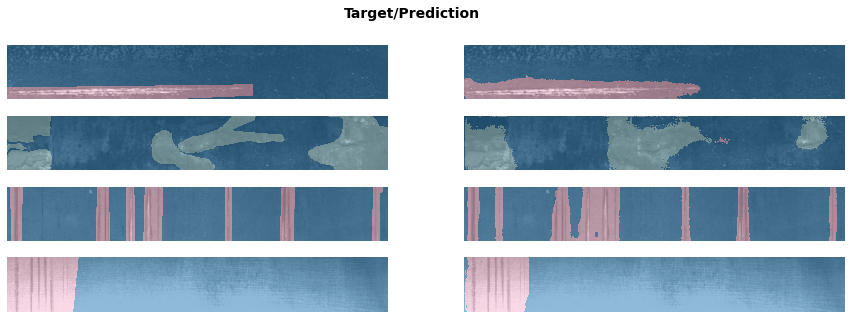

In [ ]:
fast_learner.show_results(figsize=(15,5))

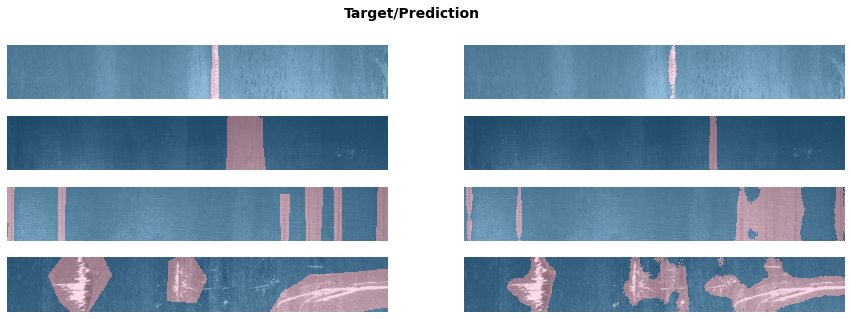

In [ ]:
fast_learner.show_results(figsize=(15,5))

### Second stage

In [ ]:
size = (224,1568)

In [ ]:
train_tfm = get_train_aug(*size)
valid_tfm = get_valid_aug(*size)

In [ ]:
dls = get_segmnt_dls(df, 
                     bs=4, 
                     train_aug=train_tfm, valid_aug=valid_tfm, 
                     device=device, 
                     flatten_mask=False)

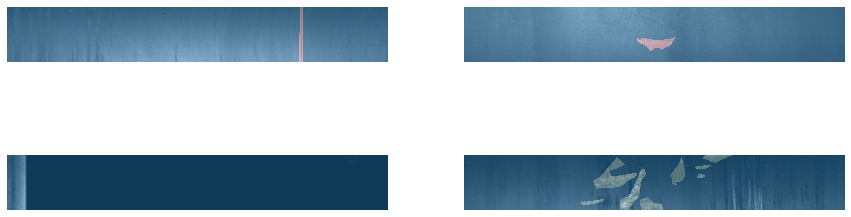

In [ ]:
dls.show_batch(figsize=(15,5))

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=5.754399353463668e-06)

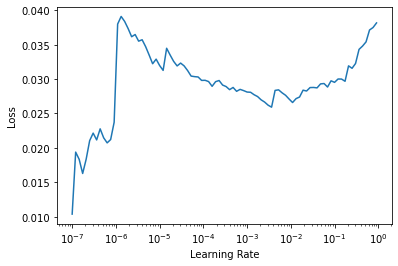

In [ ]:
fast_learner.lr_find()

In [ ]:
stage = "resnet18-DynamicUNET-stage1"

In [ ]:
fit_cbs = [
    GradientAccumulation(n_acc=16),
    CSVLogger(fname=f'{models_dir}/logs/{stage}.csv'),
    SaveModelCallback(monitor='valid_loss', fname=stage)]

epoch,train_loss,valid_loss,mod_dice_multi,kaggle_dice,time
0,0.025173,0.023054,0.143275,0.288128,34:44
1,0.025168,0.022809,0.135827,0.286417,34:38
2,0.022334,0.022841,0.135430,0.286859,34:45
3,0.028812,0.022706,0.139297,0.292386,34:41


Better model found at epoch 0 with valid_loss value: 0.02305351011455059.


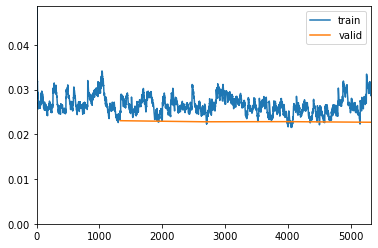

Better model found at epoch 1 with valid_loss value: 0.02280939742922783.
Better model found at epoch 3 with valid_loss value: 0.022706380113959312.


In [ ]:
fast_learner.fit_one_cycle(4, lr_max=slice(3e-5, 3e-4), cbs=fit_cbs)